# Makine Öğrenimi ile Konut Fiyat Tahmini: Final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_excel("C:\\konut\\istanbul_konut2.xlsx")

In [15]:
# Eksik değerlerin toplamını ve oranını göster
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Eksik değer tablosu oluştur
missing_data = pd.DataFrame({'Eksik Değerler': missing_values, 'Eksik Oranı (%)': missing_percent})
print(missing_data)


                 Eksik Değerler  Eksik Oranı (%)
Fiyat                         0              0.0
İlce                          0              0.0
Mahalle                       0              0.0
Metre Kare                    0              0.0
Oda Sayısı                    0              0.0
Yaş                           0              0.0
Bulunduğu Kat                 0              0.0
Ilce_encoded                  0              0.0
Mahalle_encoded               0              0.0


In [4]:
# 'Yaş' sütunundaki eksik değerleri medyan ile doldur
df['Yaş'] = df['Yaş'].fillna(df['Yaş'].median())
# 'Bulunduğu Kat' sütunundaki eksik değerleri mod ile doldur
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].fillna(df['Bulunduğu Kat'].mode()[0])
# Oda Sayısı sütunundaki eksik değerleri mod (en sık görülen değer) ile doldur
most_frequent_value = df['Oda Sayısı'].mode()[0]
df['Oda Sayısı'] = df['Oda Sayısı'].fillna(most_frequent_value)
print(df.isnull().sum())

Fiyat            0
İlce             0
Mahalle          0
Metre Kare       0
Oda Sayısı       0
Yaş              0
Bulunduğu Kat    0
dtype: int64


### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder

# İlçe ve Mahalle sütunlarını encode edin
label_encoder = LabelEncoder()
df['Ilce_encoded'] = label_encoder.fit_transform(df['İlce'])
df['Mahalle_encoded'] = label_encoder.fit_transform(df['Mahalle'])

# Outlier Değerleri Temizleme

## Hibrid Yöntem - (IQR  + Manuel Veri Temizleme)

In [6]:
df = df[df["Oda Sayısı"] < 8]
df = df[df["Yaş"] < 57]
df = df[(df["Metre Kare"] < 270) & (df["Metre Kare"] > 40)]

In [7]:
X = df[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df['Fiyat']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'Manuel Temizleme Sonrası R^2 Skoru: {r2:.4f}')
print(f'Manuel Temizleme Sonrası Veri sayısı: {len(df)}')

Manuel Temizleme Sonrası R^2 Skoru: 0.8311
Manuel Temizleme Sonrası Veri sayısı: 27613


In [8]:
# İlçe bazında Fiyat, Metre Kare, Oda Sayısı ve Yaş değişkenleri için ortalama ve standart sapma hesaplama
stats = df.groupby('Ilce_encoded').agg(
    Fiyat_mean=('Fiyat', 'mean'), Fiyat_std=('Fiyat', 'std'),
    MetreKare_mean=('Metre Kare', 'mean'), MetreKare_std=('Metre Kare', 'std'),
    OdaSayisi_mean=('Oda Sayısı', 'mean'), OdaSayisi_std=('Oda Sayısı', 'std'),
    Yas_mean=('Yaş', 'mean'), Yas_std=('Yaş', 'std')
).reset_index()

# Aykırı değer eşiğini hesaplama ve kontrol etme
def is_outlier(row, stats):
    ilce_stats = stats[stats['Ilce_encoded'] == row['Ilce_encoded']].iloc[0]
    
    # Eşik değerler
    fiyat_threshold = ilce_stats['Fiyat_mean'] + 2 * ilce_stats['Fiyat_std'] + 1
    metrekare_threshold = ilce_stats['MetreKare_mean'] + 2 * ilce_stats['MetreKare_std'] + 1
    odasayisi_threshold = ilce_stats['OdaSayisi_mean'] + 2 * ilce_stats['OdaSayisi_std'] + 1
    yas_threshold = ilce_stats['Yas_mean'] + 2 * ilce_stats['Yas_std'] + 1

    # Aykırı değer kontrolü
    if (row['Fiyat'] > fiyat_threshold or 
        row['Metre Kare'] > metrekare_threshold or 
        row['Oda Sayısı'] > odasayisi_threshold or 
        row['Yaş'] > yas_threshold):
        return True
    return False

# Aykırı değerleri filtreleme
filtered_data = df[~df.apply(lambda row: is_outlier(row, stats), axis=1)]

# Sonuç
print(f"Orijinal veri boyutu: {len(df)}")
print(f"İlçe Bazlı Temizlenme sonucu  veri boyutu: {len(filtered_data)}")


Orijinal veri boyutu: 27613
İlçe Bazlı Temizlenme sonucu  veri boyutu: 24746


In [9]:
# Özellikler ve hedef değişkeni belirleme
X = filtered_data[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = filtered_data['Fiyat']

# IQR yöntemiyle aykırı değerleri temizleme
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'IQR sonrası Veri boyutu: {len(X_clean)}')

R^2 Skoru: 0.8760
IQR sonrası Veri boyutu: 23982


# Final Model

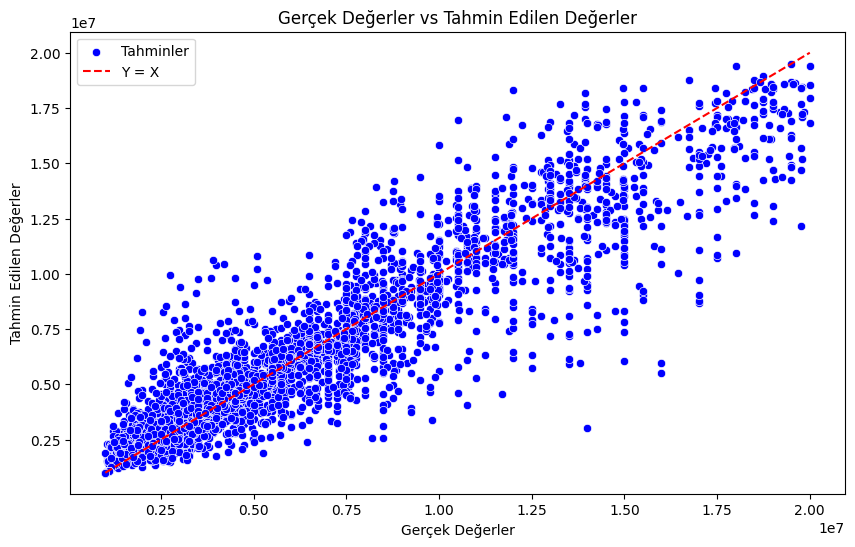

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Regresyon grafiği çizme
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Tahminler')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Y = X')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek Değerler vs Tahmin Edilen Değerler')
plt.legend()
plt.show()


In [11]:
import numpy as np

# Modelin tahmin yapması için yeni veriler
new_data = np.array([[90, 3, 10, 1, 30, 108]])  # [Metre Kare, Oda Sayısı, Yaş, Bulunduğu Kat, İlce_encoded, Mahalle_encoded]

# Modelin tahmin yapması
prediction = rf_model.predict(new_data)
# 24941	90	3.0	10.0	1.0	30	108
print(f'Tahmin Edilen Değer: {prediction[0]:.2f}')


Tahmin Edilen Değer: 1100000.00


C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Modeli Export Etme

In [12]:
import joblib

# Modeli kaydet
joblib.dump(rf_model, 'konut_tahmin_model.pkl')


['konut_tahmin_model.pkl']

In [18]:
import numpy as np

# Kullanıcıdan veri al
metre_kare = float(input("Metre Kare   : "))
oda_sayisi = float(input("Oda Sayısı   : "))
yas =        float(input("Yaş          : "))
kat =        float(input("Bulunduğu Kat: "))
ilce_encoded = float(input("İlçe Encoded    : "))
mahalle_encoded = float(input("Mahalle Encoded: "))

# Yeni veri setini oluştur
new_data = np.array([[metre_kare, oda_sayisi, yas, kat, ilce_encoded, mahalle_encoded]])

# Modelin tahmin yapması
prediction = rf_model.predict(new_data)

# Tahmin edilen değeri yazdır
print(f'Tahmin Edilen Değer: {prediction[0]:.2f}')


Metre Kare   :  128
Oda Sayısı   :  4
Yaş          :  2
Bulunduğu Kat:  9
İlçe Encoded    :  22
Mahalle Encoded:  376


Tahmin Edilen Değer: 5073083.33


C:\Users\yunus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [13]:
X_test

,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat,Ilce_encoded,Mahalle_encoded
17993,128,4.0,2.0,9.0,22,376
9994,93,2.0,6.0,3.0,15,256
8323,110,3.0,18.0,3.0,13,192
9188,120,4.0,5.0,3.0,34,188
6695,140,4.0,0.0,4.0,10,15
...,...,...,...,...,...,...
15511,110,4.0,0.0,6.0,20,178
13285,64,2.0,15.0,2.0,18,231
7542,60,2.0,42.0,3.0,11,115
10435,115,3.0,4.0,2.0,15,53


In [13]:
y_test

17993     5250000
9994      4050000
8323      3250000
9188      5850000
6695      4599000
           ...   
15511    12300000
13285     4700000
7542      8500000
10435     2150000
13610     3100000
Name: Fiyat, Length: 4797, dtype: int64